# Test breadth and depth for FFN with MNIST dataset
Here I trained FNN neural network models with MNIST dataset by varying the number of hidden layers and the number of units per layer and tracked the training time and performance. 

As seen in the last plot, the training time increases monotonically with more depth and breadth. Which is expected.

And more hidden layers as well as units per hidden layer here actually increases the model performance. Although this will depend on the dataset. For simple datasets like Iris, a simple network usually have the best performance. NN is an experimental science and needs to test lots of parameters. 

In [11]:
# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [12]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt
from IPython import display
# display.set_matplotlib_formats('svg')

# Import and process the data

In [13]:
# import dataset (comes with colab!)
with open('/Users/alexchen/Downloads/mnist/mnist_test.csv','rb') as f:
   data = np.loadtxt(f, delimiter=',', skiprows=1)
# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

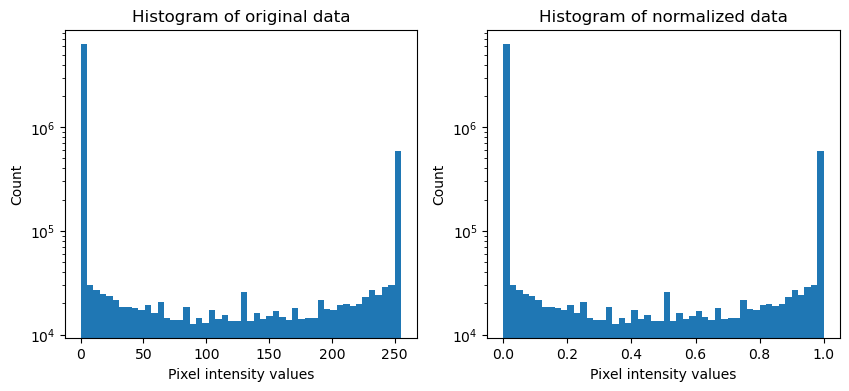

In [14]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')


plt.show()

# Create train/test groups using DataLoader

In [15]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [16]:
# create a class for the model
def createTheMNISTNet(n_layers, n_units):

  class mnistNet(nn.Module):
    def __init__(self, n_layers, n_units):
      super().__init__()

      self.n_layers = n_layers
      self.layers = nn.ModuleDict()
      ### input layer
      self.layers['input'] = nn.Linear(784,n_units)
      # hidden layer
      for i in range(self.n_layers):
        self.layers[f'fc{i}'] = nn.Linear(n_units, n_units)
      ### output layer
      self.layers['output'] = nn.Linear(n_units, 10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.layers['input'](x) )
      for i in range(self.n_layers):
        x = F.relu( self.layers[f'fc{i}'](x) )
      x = self.layers['output'](x)
      return x
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet(n_layers, n_units)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()
  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [17]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(2, 2)

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
print(yHat[0])

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([ 0.6147,  0.4511, -0.3539, -0.6750,  0.5054,  0.5410,  0.4692, -0.0656,
         0.2213, -0.3227], grad_fn=<SelectBackward0>)
 
Loss:
tensor(2.3620, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [18]:
# a function that trains the model

def funtion2trainTheModel(n_layers, n_units):

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(n_layers, n_units)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

finished running 1 layers 50 units in 8.09s, test acc 93.80%
finished running 1 layers 100 units in 8.96s, test acc 93.70%
finished running 1 layers 150 units in 10.5s, test acc 93.60%
finished running 1 layers 200 units in 12.12s, test acc 93.80%
finished running 1 layers 250 units in 14.27s, test acc 94.10%
finished running 2 layers 50 units in 8.81s, test acc 93.50%
finished running 2 layers 100 units in 10.17s, test acc 94.10%
finished running 2 layers 150 units in 11.98s, test acc 95.00%
finished running 2 layers 200 units in 15.25s, test acc 94.00%
finished running 2 layers 250 units in 16.64s, test acc 94.10%
finished running 3 layers 50 units in 9.3s, test acc 93.00%
finished running 3 layers 100 units in 11.11s, test acc 94.40%
finished running 3 layers 150 units in 12.85s, test acc 95.20%
finished running 3 layers 200 units in 17.42s, test acc 94.60%
finished running 3 layers 250 units in 20.3s, test acc 94.40%


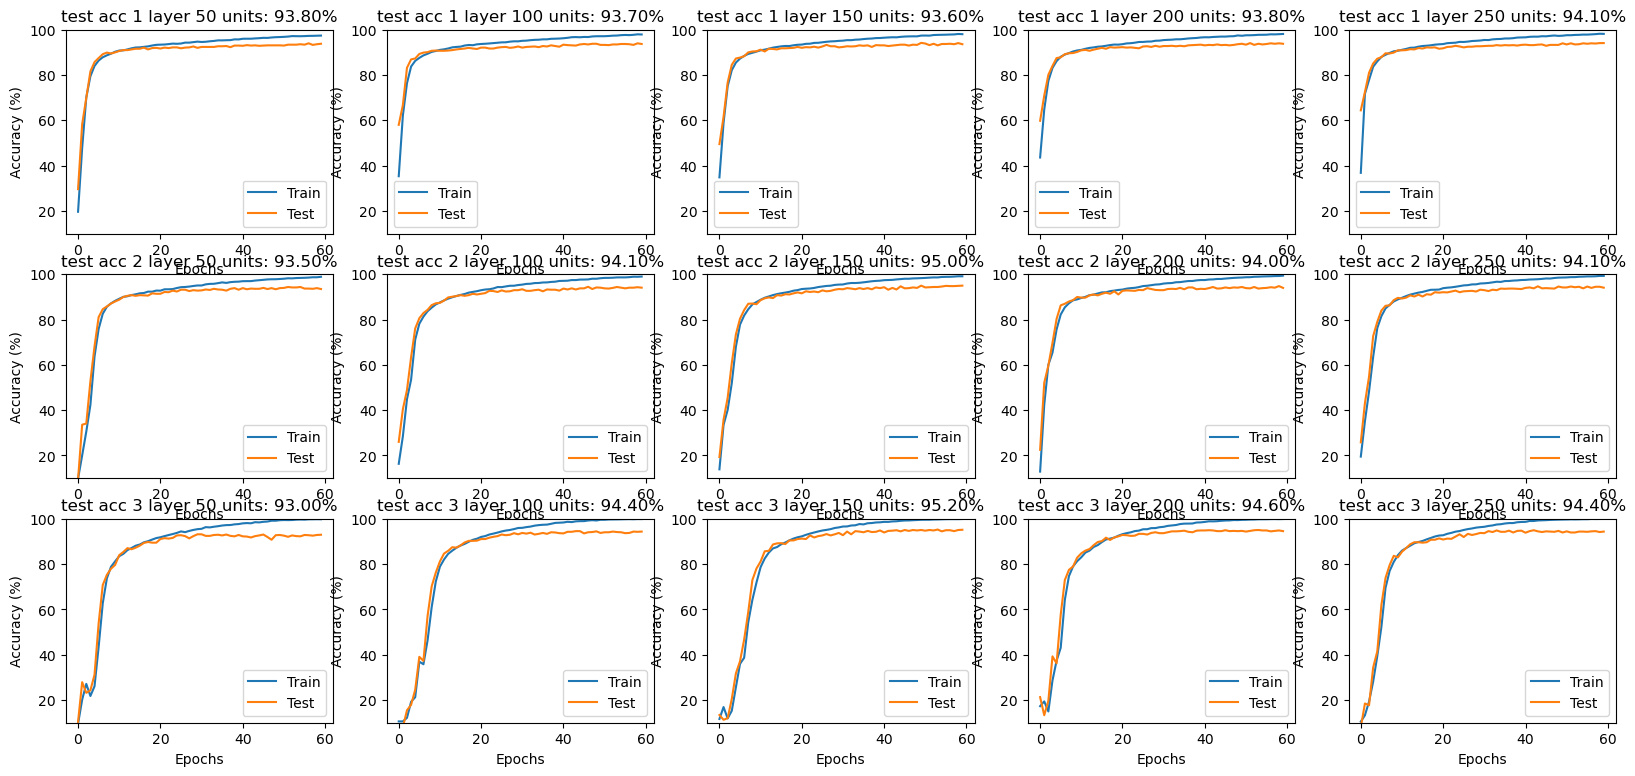

In [19]:
layers_lst = [1,2,3]
units_lst = [50, 100, 150, 200, 250]

numepochs = 60
all_trainAccs = np.zeros((len(layers_lst), len(units_lst), numepochs))
all_testAccs = np.zeros((len(layers_lst), len(units_lst), numepochs))
all_elapsed = np.zeros((len(layers_lst), len(units_lst)))

fig, ax = plt.subplots(len(layers_lst), len(units_lst), figsize=(len(units_lst)*4, len(layers_lst)*3))
for i_layers, layers in enumerate(layers_lst):
    for j_units, units in enumerate(units_lst):
        start = time.time()
        trainAcc,testAcc,losses,net = funtion2trainTheModel(layers, units)
        all_trainAccs[i_layers, j_units] = trainAcc
        all_testAccs[i_layers, j_units] = testAcc
        elapsed = time.time() - start
        all_elapsed[i_layers, j_units] = elapsed
        print(f'finished running {layers} layers {units} units in {round(elapsed, 2)}s, test acc {testAcc[-1]:.2f}%')

for i_layers, layers in enumerate(layers_lst):
    for j_units, units in enumerate(units_lst):
        trainAcc = all_trainAccs[i_layers, j_units]
        testAcc = all_testAccs[i_layers, j_units]
        ax[i_layers, j_units].plot(trainAcc, label='Train')
        ax[i_layers, j_units].plot(testAcc, label='Test')
        ax[i_layers, j_units].set_xlabel('Epochs')
        ax[i_layers, j_units].set_ylabel('Accuracy (%)')
        ax[i_layers, j_units].set_ylim([10,100])
        ax[i_layers, j_units].set_title(f'test acc {layers} layer {units} units: {testAcc[-1]:.2f}%')
        ax[i_layers, j_units].legend()
plt.show()

Text(0.5, 0, 'Units per hidden layer')

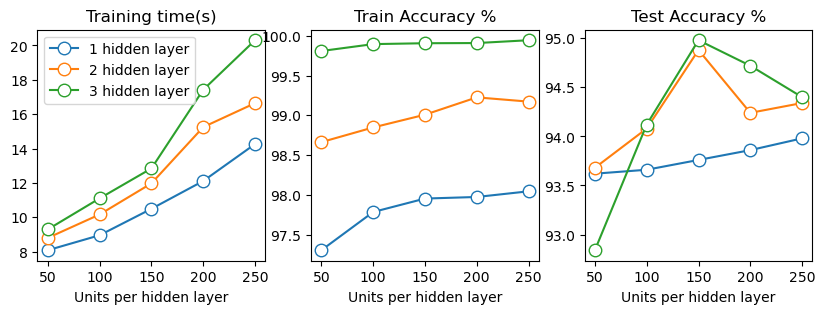

In [36]:
# plot the train and test data
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(units_lst, all_elapsed.T, 'o-',markerfacecolor='w',markersize=9)
axes[0].set_title('Training time(s)')
axes[0].set_xlabel('Units per hidden layer')
axes[0].legend([f'{i} hidden layer' for i in layers_lst])
axes[1].plot(units_lst, np.mean(all_trainAccs[:, :, -5:], axis=2).T, 'o-',markerfacecolor='w',markersize=9)
axes[1].set_title('Train Accuracy %')
axes[1].set_xlabel('Units per hidden layer')
axes[2].plot(units_lst, np.mean(all_testAccs[:, :, -5:], axis=2).T, 'o-',markerfacecolor='w',markersize=9)
axes[2].set_title('Test Accuracy %')
axes[2].set_xlabel('Units per hidden layer')